In [2]:
import h5py
import numpy as np
from torch.utils.data import Dataset

class SudokuDataset(Dataset):
    def __init__(self, h5_file_path, transform=None):
        self.h5_file_path = h5_file_path
        self.transform = transform

        # Load the HDF5 data
        with h5py.File(h5_file_path, 'r') as f:
            self.images = np.array(f['images'])  # Shape: (N, 84, 84)
            self.labels = np.array(f['labels'])  # Shape: (N,)
        if len(self.images) > len(self.labels):
            print(f"Trimming images from {len(self.images)} to {len(self.labels)} to match labels.")
            self.images = self.images[:len(self.labels)]
        

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # Shape: (84, 84)
        label = self.labels[idx]  # Label

        # Reshape and normalize the image
        image = image.reshape(1, 84, 84).astype(np.float32) / 255.0  # Shape: (1, 84, 84)

        return image, label


In [3]:
import torch
from torch.utils.data import DataLoader, Subset
from collections import Counter
from torchvision import transforms

# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load Dataset from separate files
train_file_path = '/kaggle/input/sudoku-images-based-on-mnist/sudoku_training_set.h5'  # Update with your training file path
val_file_path = '/kaggle/input/sudoku-images-based-on-mnist/sudoku_validation_images_20k.h5'  # Update with your validation file path

# Assuming the dataset class can accept a file path
train_dataset = SudokuDataset(train_file_path, transform=transform)
val_dataset = SudokuDataset(val_file_path, transform=transform)

# Step 1: Determine Class Distribution in Training Dataset
all_labels = [train_dataset[i][1] for i in range(len(train_dataset))]  # Get all labels from the train set
class_counts = Counter(all_labels)  # Count samples per class
print("Class Distribution in Training Set:", class_counts)

# Step 2: Identify Minority Class Count
min_class_count = min(class_counts.values())

# Step 3: Balance the Training Dataset
balanced_train_indices = []
class_sample_counts = {cls: 0 for cls in class_counts.keys()}

# Balance only the training dataset
for idx, (data, label) in enumerate(train_dataset):
    if class_sample_counts[label] < min_class_count:
        balanced_train_indices.append(idx)
        class_sample_counts[label] += 1

# Create a balanced subset of the training dataset
balanced_train_dataset = Subset(train_dataset, balanced_train_indices)
print("Balanced Train Dataset Size:", len(balanced_train_dataset))

# Step 4: Create DataLoaders
train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Output Dataset Information
print(f"Train Dataset Size: {len(balanced_train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")

Trimming images from 440000 to 435000 to match labels.
Class Distribution in Training Set: Counter({False: 250000, True: 185000})
Balanced Train Dataset Size: 370000
Train Dataset Size: 370000
Validation Dataset Size: 10000


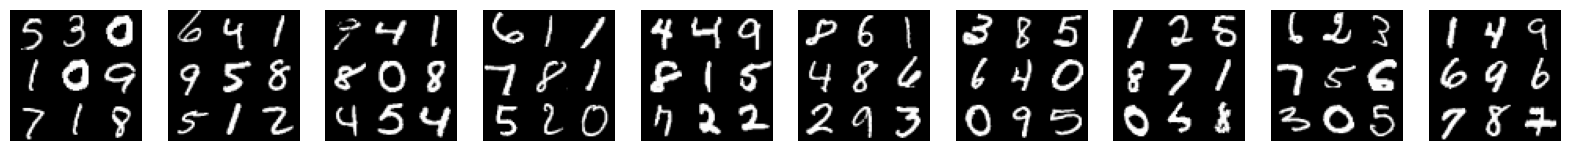

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

images, labels = next(iter(train_loader))

# Plot the images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    # Convert the tensor image to numpy array for displaying
    img = images[i].numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    img = np.clip(img, 0, 1)  # Ensure pixel values are between 0 and 1

    axes[i].imshow(img.squeeze(), cmap='gray')  # If grayscale, use cmap='gray'
    axes[i].axis('off')

plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class EncoderAE(nn.Module):
    def __init__(self, latent_dim):
        super(EncoderAE, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)  # Output: [batch, 32, 42, 42]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # Output: [batch, 64, 21, 21]
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # Output: [batch, 128, 11, 11]
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # Output: [batch, 256, 6, 6]
        self.fc1 = nn.Linear(256 * 6 * 6, 1024)
        self.fc2 = nn.Linear(1024, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, 256*6*6]
        x = F.relu(self.fc1(x))
        z = self.fc2(x)  # Latent representation
        return z

class DecoderAE(nn.Module):
    def __init__(self, latent_dim):
        super(DecoderAE, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 128 * 21 * 21)  # Flatten to match the size before upsampling
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)  # Output: [batch, 64, 42, 42]
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)   # Output: [batch, 32, 84, 84]
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)  # Keep size 84x84

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = z.view(z.size(0), 128, 21, 21)  # Reshape to [batch_size, 128, 21, 21]
        z = F.relu(self.deconv1(z))  # Upsample to [batch_size, 64, 42, 42]
        z = F.relu(self.deconv2(z))  # Upsample to [batch_size, 32, 84, 84]
        x_reconstructed = torch.sigmoid(self.deconv3(z))  # Final output [batch_size, 1, 84, 84]
        return x_reconstructed

# Define AE Model
class AE(nn.Module):
    def __init__(self, latent_dim):
        super(AE, self).__init__()
        self.encoder = EncoderAE(latent_dim)
        self.decoder = DecoderAE(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed

class AEWithClassifier(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(AEWithClassifier, self).__init__()
        self.encoder = EncoderAE(latent_dim)
        self.decoder = DecoderAE(latent_dim)
        self.fc_classifier = nn.Linear(latent_dim, num_classes)  # Fully connected layer for classification

    def forward(self, x):
        z = self.encoder(x)  # Latent representation
        x_reconstructed = self.decoder(z)  # Reconstructed image
        class_logits = self.fc_classifier(z)  # Classification logits
        return x_reconstructed, class_logits



In [6]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Define the AE loss function (Reconstruction loss) + Classification loss
def ae_loss(reconstructed_images, images, class_logits, labels):
    # Reconstruction loss (Mean Squared Error)
    reconstruction_loss = F.mse_loss(reconstructed_images, images, reduction='sum')
    
    # Classification loss (Cross-Entropy)
    classification_loss = F.cross_entropy(class_logits, labels)
    
    total_loss = reconstruction_loss + classification_loss
    return total_loss, reconstruction_loss, classification_loss

# Calculate accuracy
def calculate_accuracy(logits, labels):
    _, predicted = torch.max(logits, 1)  # Get the index of the max logit (predicted class)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

def train_ae_classifier(train_loader, val_loader, model, optimizer, num_epochs, device):
    model.to(device)
    best_val_loss = float('inf')  # Track the best validation loss

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_reconstruction_loss = 0.0
        running_classification_loss = 0.0
        train_accuracy = 0.0
        total_train = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)  # Move images to the correct device
            labels = labels.to(device).long()  # Ensure labels are of type long (for cross_entropy)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            reconstructed_images, class_logits = model(images)

            # Compute the combined loss
            total_loss, reconstruction_loss, classification_loss = ae_loss(reconstructed_images, images, class_logits, labels)

            # Backward pass and optimize
            total_loss.backward()
            optimizer.step()

            # Update statistics
            running_loss += total_loss.item()
            running_reconstruction_loss += reconstruction_loss.item()
            running_classification_loss += classification_loss.item()

            # Calculate training accuracy
            accuracy = calculate_accuracy(class_logits, labels)
            train_accuracy += accuracy * images.size(0)
            total_train += images.size(0)

        # Average loss and accuracy for this epoch
        avg_loss = running_loss / total_train
        avg_reconstruction_loss = running_reconstruction_loss / total_train
        avg_classification_loss = running_classification_loss / total_train
        avg_train_accuracy = train_accuracy / total_train

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Loss: {avg_loss:.4f}, "
              f"Reconstruction Loss: {avg_reconstruction_loss:.4f}, "
              f"Classification Loss: {avg_classification_loss:.4f}, "
              f"Train Accuracy: {avg_train_accuracy:.4f}")

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_accuracy = 0.0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device).long()  # Ensure labels are of type long

                # Forward pass
                reconstructed_images, class_logits = model(images)

                # Compute the combined loss
                total_loss, reconstruction_loss, classification_loss = ae_loss(reconstructed_images, images, class_logits, labels)

                # Update statistics
                val_loss += total_loss.item()

                # Calculate validation accuracy
                accuracy = calculate_accuracy(class_logits, labels)
                val_accuracy += accuracy * images.size(0)
                total_val += images.size(0)

        # Average validation loss and accuracy
        avg_val_loss = val_loss / total_val
        avg_val_accuracy = val_accuracy / total_val
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")

        # Save the model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_file = f"ae_classifier_epoch_{epoch+1}.pth"
            torch.save(model.state_dict(), save_file)
            print(f"Model saved to {save_file}")


In [7]:
# Define the number of classes for the classification task
num_classes = 2  

# Instantiate the model with a latent space dimension of 128
latent_dim = 128
model = AEWithClassifier(latent_dim, num_classes)

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Number of epochs
num_epochs = 10

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
train_ae_classifier(train_loader, val_loader, model, optimizer, num_epochs, device)


Epoch 1/10, Loss: 356.7301, Reconstruction Loss: 356.7103, Classification Loss: 0.0198, Train Accuracy: 0.5339
Validation Loss: 314.7085, Validation Accuracy: 0.5040
Model saved to ae_classifier_epoch_1.pth
Epoch 2/10, Loss: 259.9773, Reconstruction Loss: 259.9672, Classification Loss: 0.0101, Train Accuracy: 0.5702
Validation Loss: 276.8573, Validation Accuracy: 0.4962
Model saved to ae_classifier_epoch_2.pth
Epoch 3/10, Loss: 236.2955, Reconstruction Loss: 236.2855, Classification Loss: 0.0100, Train Accuracy: 0.5724
Validation Loss: 261.3515, Validation Accuracy: 0.4911
Model saved to ae_classifier_epoch_3.pth
Epoch 4/10, Loss: 222.1397, Reconstruction Loss: 222.1297, Classification Loss: 0.0100, Train Accuracy: 0.5709
Validation Loss: 253.4239, Validation Accuracy: 0.4856
Model saved to ae_classifier_epoch_4.pth
Epoch 5/10, Loss: 213.6965, Reconstruction Loss: 213.6865, Classification Loss: 0.0100, Train Accuracy: 0.5697
Validation Loss: 245.4167, Validation Accuracy: 0.4909
Model 

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate classification accuracy and visualize reconstructions
def evaluate_and_visualize(model, test_loader, device):
    all_true_labels = []
    all_pred_labels = []
    images_batch = None
    reconstructions_batch = None

    class_correct = [0] * 2
    class_total = [0] * 2

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            reconstructed_images, class_logits = model(images)

            pred_labels = torch.argmax(class_logits, dim=1)

            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(pred_labels.cpu().numpy())

            for i in range(labels.size(0)):
                label = labels[i].item()
                pred_label = pred_labels[i].item()

                if label == pred_label:
                    class_correct[label] += 1
                class_total[label] += 1

            if batch_idx == 0:
                images_batch = images.cpu().numpy()
                if reconstructed_images is not None:
                    reconstructions_batch = reconstructed_images.cpu().numpy()

    # Compute overall accuracy
    accuracy = accuracy_score(all_true_labels, all_pred_labels)
    print(f"Classification Accuracy on Test Set: {accuracy * 100:.2f}%")

    # Print per-class accuracy
    for i in range(len(class_correct)):
        if class_total[i] > 0:
            per_class_accuracy = 100 * class_correct[i] / class_total[i]
            print(f"Class {i} Accuracy: {per_class_accuracy:.2f}%")

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_true_labels, all_pred_labels, average='weighted')
    recall = recall_score(all_true_labels, all_pred_labels, average='weighted')
    f1 = f1_score(all_true_labels, all_pred_labels, average='weighted')

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    if reconstructions_batch is not None:
        visualize_reconstruction(images_batch, reconstructions_batch)

# Function to visualize original and reconstructed images
def visualize_reconstruction(original_images, reconstructed_images):
    original_images = original_images.squeeze()
    reconstructed_images = reconstructed_images.squeeze()

    num_images = 10
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))

    for i in range(num_images):
        axes[0, i].imshow(original_images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original {i + 1}")

        axes[1, i].imshow(reconstructed_images[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Reconstructed {i + 1}")

    plt.show()


/tmp/ipykernel_30/1577331237.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/ae-best-model/ae_classifier_epoch_1(1).pth'

Classification Accuracy on Test Set: 51.01%
Class 0 Accuracy: 65.38%
Class 1 Accuracy: 36.64%
Precision: 0.51
Recall: 0.51
F1 Score: 0.50


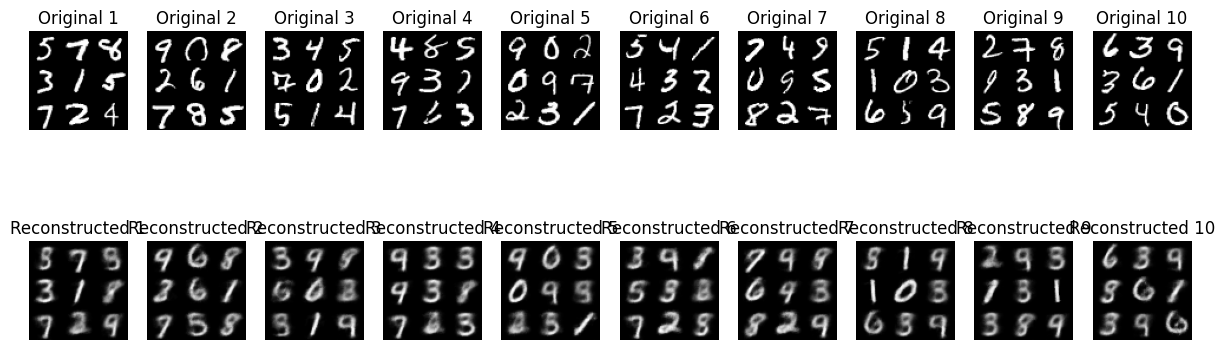

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the test dataset using your custom SudokuDataset class
h5_file_path = '/kaggle/input/sudoku-images-based-on-mnist/sudoku_testing_images.h5'
test_dataset = SudokuDataset(h5_file_path)

# Test DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
num_classes = 2  

latent_dim = 128
model = AEWithClassifier(latent_dim, num_classes)

model.eval()  
model.to(device) 
for i in range(1,2):
    model.load_state_dict(torch.load('/kaggle/input/ae-best-model/ae_classifier_epoch_1(1).pth'))  # Adjust path to best model
    evaluate_and_visualize(model, test_loader, device)
